# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [9]:
from enum import Enum, auto

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [18]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

class Activations(Enum):
  softmax = auto()
  sigmoid = auto()

activation_funcs = {
      Activations.softmax: tf.nn.softmax,
      Activations.sigmoid: tf.nn.sigmoid,
}

In [11]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="DL1")
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="DL2")
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="EL")

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x, activation=Activations.softmax)

In [15]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true_h = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes, dtype=tf.float32)
    # print(f"cross_entropy {y_true=}")

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
    #print(f"{y_true_h.shape=}")
    #print(f"{y_pred.shape=}")
    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true_h * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # Convert predicted probabilities to predicted labels
    #print(f"{y_pred=}")
    y_pred_labels = tf.argmax(y_pred, axis=1)

    # Compare predicted labels with true labels
    y_true = tf.cast(y_true, tf.float32)
    y_pred_labels = tf.cast(y_pred_labels, tf.float32)
    correct_predictions = tf.equal(y_pred_labels, y_true)

    # Compute accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

In [16]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(model, input_x, output_y, learning_rate=learning_rate):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.Adam(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = model(input_x)
    loss = cross_entropy(pred, output_y)

  # Отримаємо градієнти відносно ваг
  gradients = g.gradient(loss, model.trainable_variables)
  # Оновлення ваг за допомогою градієнтного спуску
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # # Модифікуємо параметри
  # model.trainable_variables[0].assign_sub(learning_rate * gradients[0])
  # model.trainable_variables[1].assign_sub(learning_rate * gradients[1])

  # Або одна команда:
  #optimizer.minimize(loss, model.trainable_variables)
  return loss

In [19]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # print(batch_x)
    # print(f"{batch_y.dtype=}")
    train(neural_net, batch_x, batch_y, learning_rate=0.002)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        # print(batch_y.shape)
        # print(pred.shape)
        current_loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        loss_history.append(current_loss)
        print(f"Step {step:4}, Loss: {current_loss:7.2f}, Accuracy: {acc:.2%}")
        if acc > 0.99:
          print("Break by accuracy")
          break

Step  100, Loss:  255.41, Accuracy: 73.44%
Step  200, Loss:  152.18, Accuracy: 83.59%
Step  300, Loss:   94.59, Accuracy: 89.45%
Step  400, Loss:   88.17, Accuracy: 90.62%
Step  500, Loss:   48.03, Accuracy: 95.31%
Step  600, Loss:   67.14, Accuracy: 92.97%
Step  700, Loss:   52.98, Accuracy: 95.70%
Step  800, Loss:   72.93, Accuracy: 94.14%
Step  900, Loss:   25.60, Accuracy: 97.66%
Step 1000, Loss:   51.37, Accuracy: 94.53%
Step 1100, Loss:   60.63, Accuracy: 92.97%
Step 1200, Loss:    9.63, Accuracy: 99.61%
Break by accuracy


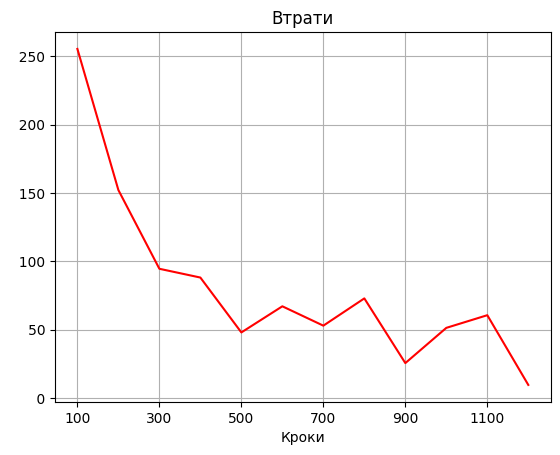

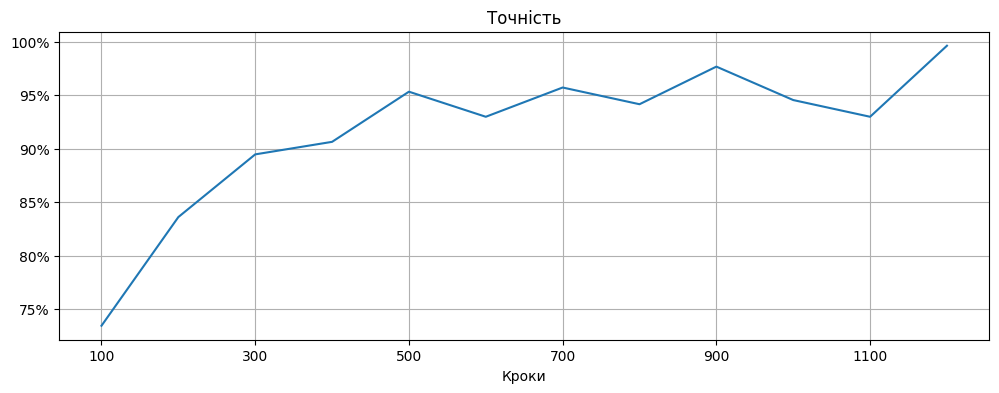

In [20]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, "r")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):5}'))
plt.xlabel("Кроки")
plt.title("Втрати")
plt.grid()
#plt.show()
# Виведіть графік точності
# Місце для вашого коду
fig = plt.figure(figsize=(12,4))
plt.plot(accuracy_history)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.title("Точність")
plt.xlabel("Кроки")
plt.grid()
plt.show()

# Виведіть графік точності
# Місце для вашого коду


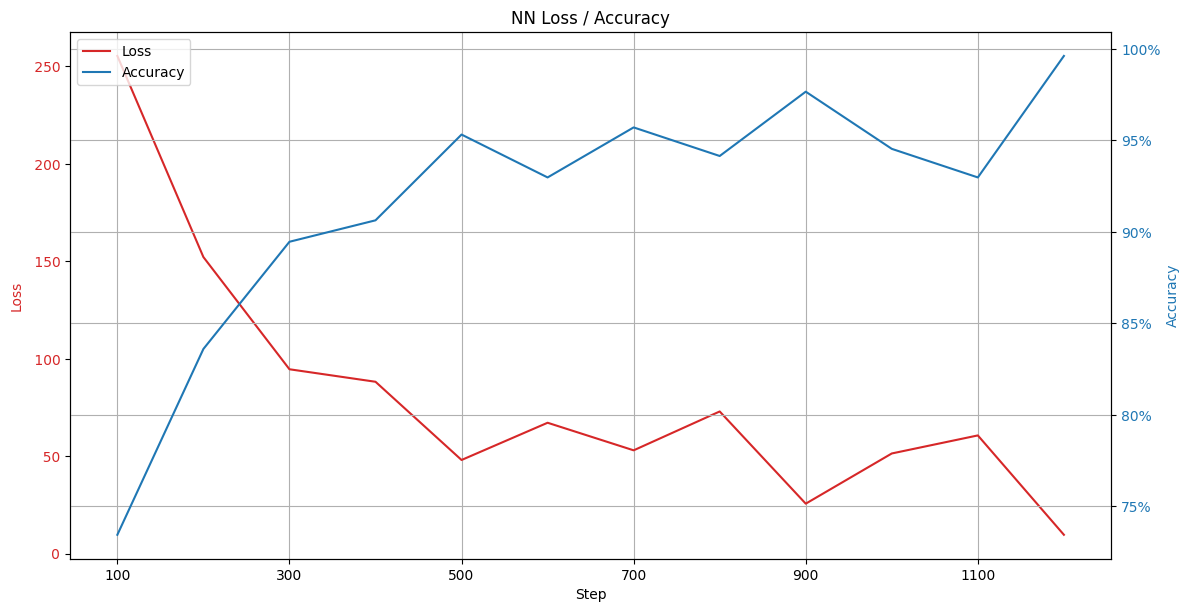

In [21]:
fig, ax1 = plt.subplots()
fig.set_size_inches((12,6))

color = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_history, color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1) * display_step)))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):4}'))
ax1.set_xticks(np.arange(0, len(loss_history)+1, step=2))  # Set label locations.
#ax1.legend()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
p2=ax2.plot(accuracy_history, color=color, label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
#ax2.legend()
#ax1.grid()
ax2.grid()
ax1.xaxis.grid(True)

# Combine the legends from ax1 and ax2
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("NN Loss / Accuracy")
plt.show()

In [22]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
acc_mean = np.mean(accuracy_history)
print(f"{acc_mean=:%}")
# Тестування моделі на тестових даних
# Місце для вашого коду
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test).numpy()
test_pred_values = np.argmax(test_pred, axis=1)
print(f"{test_acc=:%}")

acc_mean=91.666669%
test_acc=92.420000%


In [23]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
testing_select = 10
test_pred_10 = neural_net(x_test[:testing_select])
test_acc_10 = accuracy(test_pred_10, y_test[:testing_select]).numpy()
print(f"{testing_select=}, {test_acc_10=:.2%}")


img_selected = 5
sub_tests = 100
acc_list = []
for i in range(sub_tests):
  random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)
  pred = neural_net(x_test[random_img_idx])
  acc = accuracy(pred, y_test[random_img_idx]).numpy()
  acc_list.append(acc)

mean_acc = np.mean(acc_list)
print(f"{sub_tests=} by {img_selected}: {mean_acc=:.2%}")
print(f"selected imnage idx: {random_img_idx}")
print("test_values:", y_test[random_img_idx])

pred_values = np.argmax(pred, axis=1)
print("pred_values:", pred_values)
print(f"accuraccy : {acc:.2%}")




testing_select=10, test_acc_10=90.00%
sub_tests=100 by 5: mean_acc=92.00%
selected imnage idx: [9264 2581 3383 2345 7272]
test_values: [0 5 6 9 3]
pred_values: [0 5 6 9 3]
accuraccy : 100.00%


In [24]:
target_names = [ f"Number: {i}" for i in range(0, num_classes)]
print(classification_report(y_test, test_pred_values, target_names=target_names))
cr = classification_report(y_test, test_pred_values, target_names=target_names, output_dict=True)
print(cr["accuracy"])

              precision    recall  f1-score   support

   Number: 0       0.92      0.98      0.95       980
   Number: 1       0.98      0.98      0.98      1135
   Number: 2       0.91      0.94      0.92      1032
   Number: 3       0.90      0.92      0.91      1010
   Number: 4       0.92      0.92      0.92       982
   Number: 5       0.90      0.91      0.90       892
   Number: 6       0.97      0.92      0.95       958
   Number: 7       0.90      0.93      0.92      1028
   Number: 8       0.93      0.86      0.89       974
   Number: 9       0.92      0.87      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

0.9242


In [25]:
cm = confusion_matrix(y_test, test_pred_values, labels=range(10))
cm

array([[ 962,    0,    5,    2,    0,    2,    3,    3,    2,    1],
       [   0, 1114,    4,    2,    0,    0,    6,    2,    7,    0],
       [  17,    3,  967,   13,    8,    3,    6,   11,    4,    0],
       [   1,    4,   15,  928,    0,   31,    0,   14,   10,    7],
       [   6,    2,   11,    0,  900,    3,    3,    8,   12,   37],
       [  13,    4,    6,   21,    6,  809,    7,    8,   15,    3],
       [  18,    3,   12,    0,   11,   17,  886,    4,    7,    0],
       [   4,    3,   23,   10,    3,    1,    0,  961,    1,   22],
       [  14,    3,   14,   44,    8,   28,    2,   12,  840,    9],
       [  13,    6,    2,   16,   42,    7,    1,   40,    7,  875]])

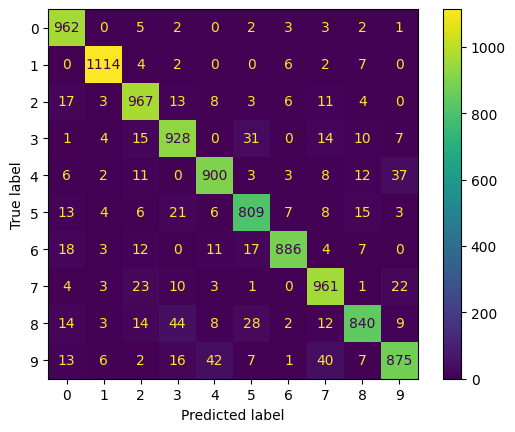

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values  )
plt.show()

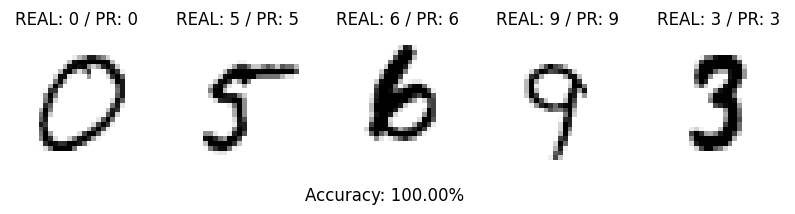

In [27]:
# Plot the images
colors = [(1, 1, 1), (1, 0, 0), (1, 0, 0)]  # white, red, red
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(10, 5))
img_size = int(x_test.shape[1]**(1/2))
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i)
    correct = y_test[idx] == pred_values[i-1]
    cmap = 'gray_r' if correct else custom_cmap
    color = "black" if correct else "red"
    plt.imshow(x_test[idx].reshape(img_size, img_size), cmap=cmap)
    plt.title(f'REAL: {y_test[idx]} / PR: {pred_values[i-1]}', color=color)
    plt.axis('off')

plt.suptitle(f"Accuracy: {acc:.2%}")
plt.subplots_adjust(top=2.2)
plt.show()

In [28]:
print(f"При тестуванні {x_test.shape[0]} тестових зображень середня похибка склала: {1-cr['accuracy']:.2%}")
print(f"На вибірці з {img_selected} зображень на {sub_tests} тестуваннях середня похибка склала: {1-mean_acc:.2%}")

При тестуванні 10000 тестових зображень середня похибка склала: 7.58%
На вибірці з 5 зображень на 100 тестуваннях середня похибка склала: 8.00%


Загальна точнічть роботи моделі на основі трестувань 10'000 зображень за f1 склала 92%, найгірша якість знаходжнеея цифри "8" (90%), найкарща для цифри "1" (98%).